In [3]:
# R libraries: Seurat, SeuratObject, zellkonverter, basilisk
# Read in RDS file into R: sce_nn <- Seurat::as.SingleCellExperiment(SKS_All_nncNeu_CTsc05_integrated,assay='RNA')
# Convert to SingleCellExperiment (SCE) Object: sce_nn <- Seurat::as.SingleCellExperiment(SKS_All_nncNeu_CTsc05_integrated,assay='RNA')
# Write SCE object to h5ad file: writeH5AD(sce_nn,'nn.h5ad')

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from scvi_colab import install
install()
run_outside_colab=True
import scvi
import scipy.sparse
import decoupler as dc
import torch
import gzip
from gtfparse import read_gtf
from pybiomart import Dataset,Server

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

from rds2py import as_summarized_experiment, read_rds

/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readt

Last run with scvi-tools version: 1.0.4


In [4]:
############## Read in GENCODE for protein coding genes ################
gencode=read_gtf("../../gencode.v44.annotation.gtf")
protein_coding_genes = list(gencode.gene_name[np.where((gencode.feature=='gene')
            &(gencode.gene_type=='protein_coding')
            )[0]])


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [5]:
clr_scheme = {'Endothelial': '#94af97','VLMC': '#50b2ad','Astro': '#a19922','Micro': '#0d5b78','Oligo': '#935f50','OPC': '#b1b10c',
             'L56NP': '#df70ff','L5ET': '#697255','L6IT': '#b1ec30','L5IT': '#da808c','L6CT': '#3e9e64','L4IT': '#a45fbf','L23IT': '#71238c',
              'L6b': '#2d8cb8','L6ITCar3': '#665c47',
              'Lamp5': '#7044aa','Chandelier': '#374a45','Pax6': '#8d6c62','SstChodl': '#53776c','Sst': '#d93137','Vip': '#00e5e5','Sncg': '#5100ff',
              'Lamp5Lhx6': '#f641a8','Pvalb': '#ff9900'}

In [4]:
glia = sc.read('../../SCORCH_HIV_data/glia.h5ad')
glia.var_names=glia.var_names.str.upper()
glia.var['gene_ids'] = glia.var_names
glia.var=glia.var.reset_index(drop=True)
glia

AnnData object with n_obs × n_vars = 195112 × 62715
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident'
    var: 'gene_ids'
    uns: 'X_name'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


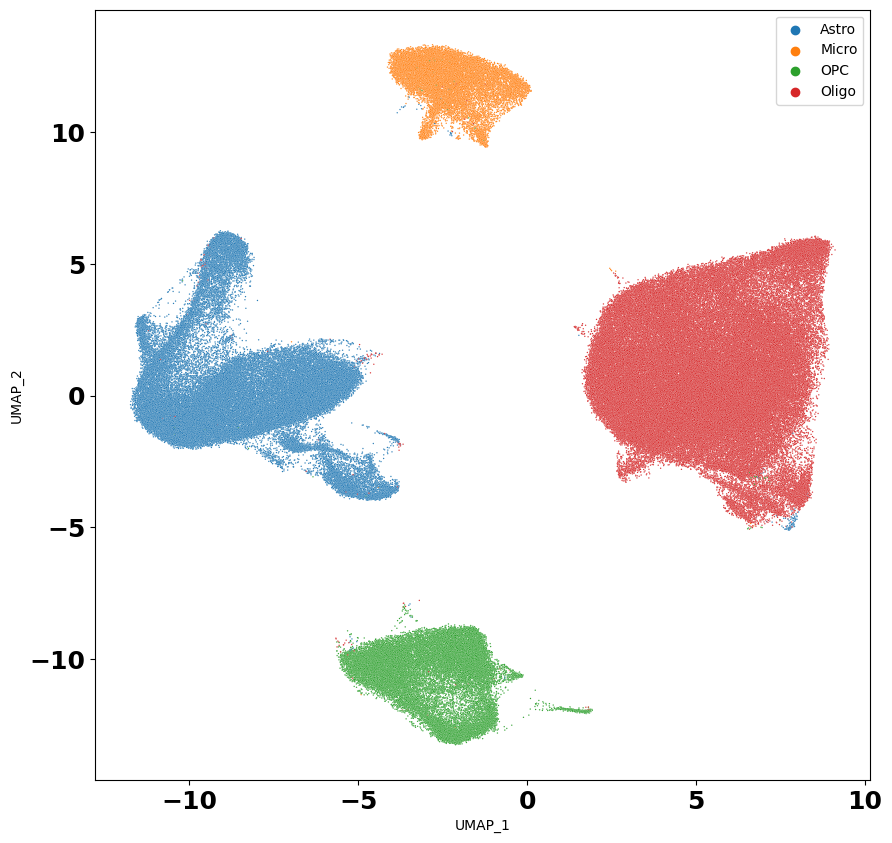

In [5]:
plt.figure(figsize = (10,10))
sns.scatterplot(x=glia.obsm.get('UMAP').iloc[:,0],
            y=glia.obsm.get('UMAP').iloc[:,1],
            #c=glia.layers.get('logcounts')[:,np.where(glia.var==gene)[0]].toarray(),
            hue=glia.obs.subclass,
            s=1, cmap='Reds'
           )
plt.xticks(size = 18, weight = 'bold')
plt.yticks(size = 18, weight = 'bold')
plt.legend()

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


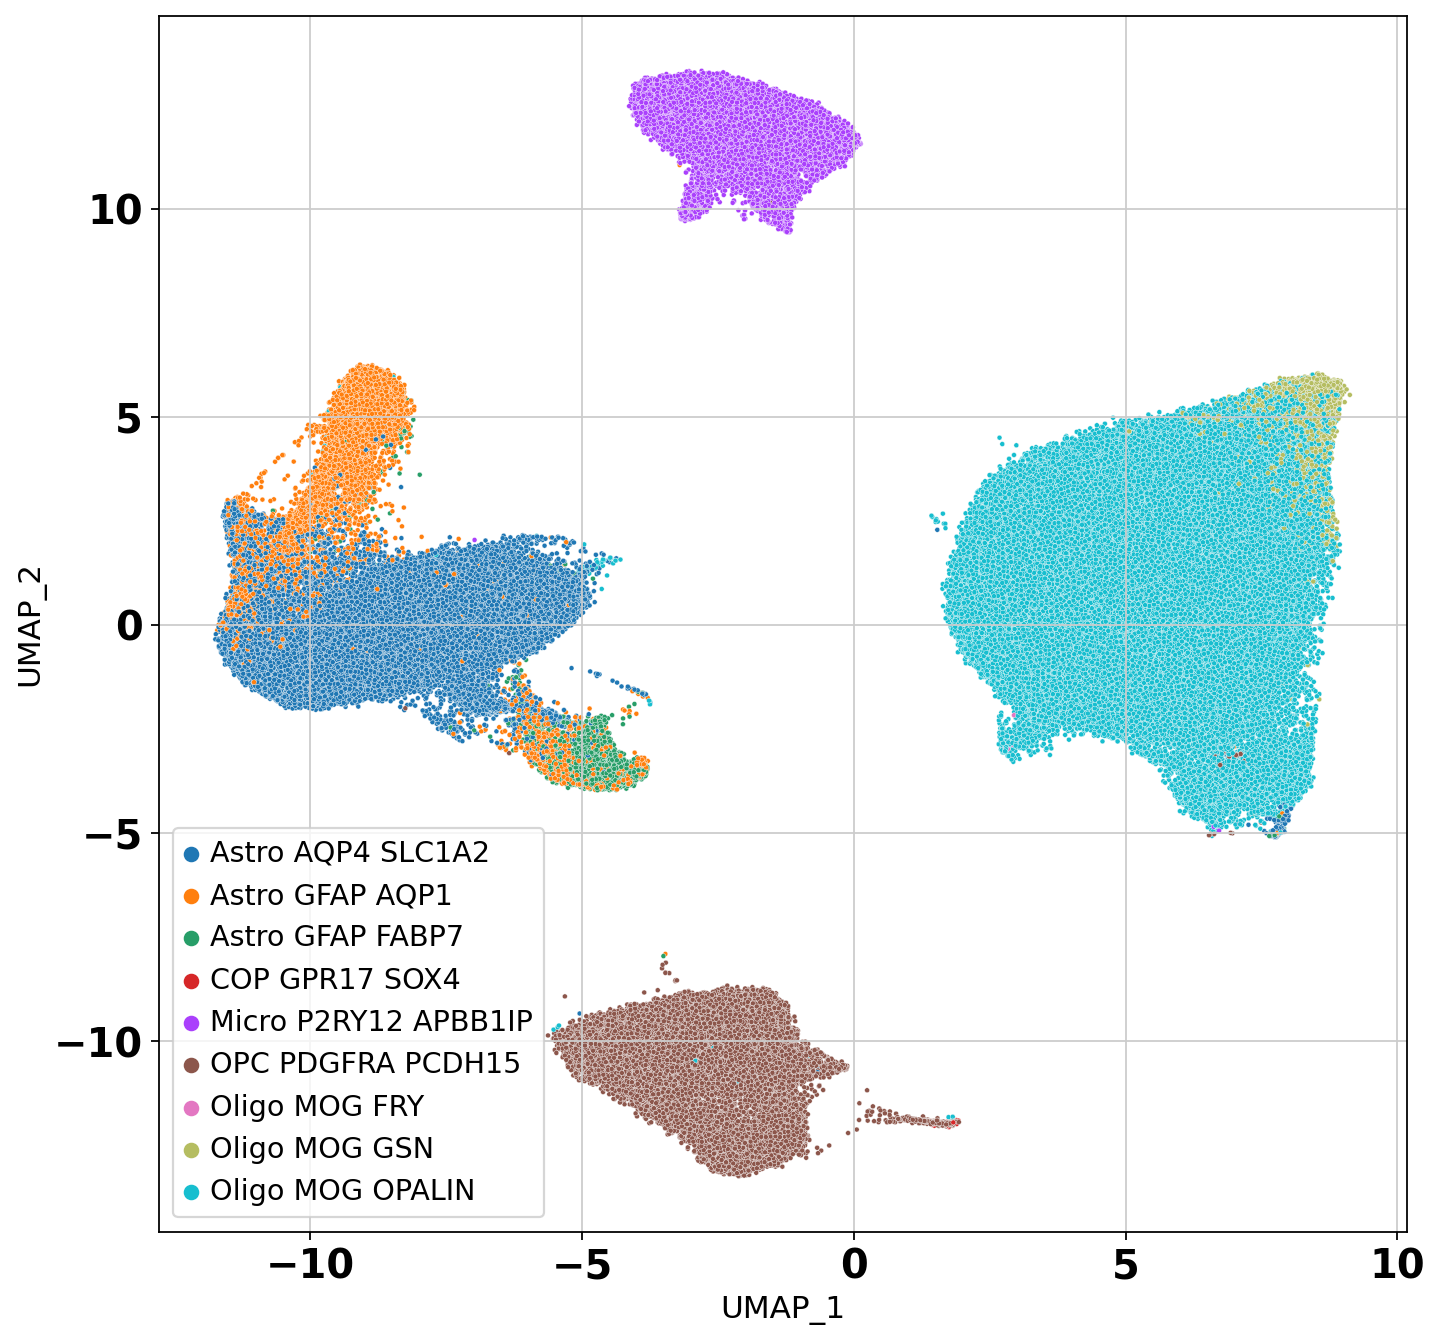

In [13]:
plt.figure(figsize = (10,10))
sns.scatterplot(x=glia.obsm.get('UMAP').iloc[:,0],
            y=glia.obsm.get('UMAP').iloc[:,1],
            #c=glia.layers.get('logcounts')[:,np.where(glia.var==gene)[0]].toarray(),
            hue=glia.obs.subtype,
            s=5, cmap='Reds'
           )
plt.xticks(size = 18, weight = 'bold')
plt.yticks(size = 18, weight = 'bold')
plt.legend()

In [6]:
sc.pp.filter_cells(glia, min_genes = 200)
sc.pp.filter_genes(glia, min_cells = 10)
glia

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 195112 × 41740
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

In [7]:
sc.pp.highly_variable_genes(
    glia,
    n_top_genes=10000,
    subset=True,
    layer="logcounts",
    flavor="seurat_v3",
    batch_key="study",
)

In [8]:
scvi.model.SCVI.setup_anndata(glia)
vae = scvi.model.SCVI(glia)
vae.train()
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df.index = df.index.map(lambda x: x[:-2])
df.index=glia.obs.index
glia.obs['doublet'] = df['prediction']
glia = glia[glia.obs.doublet == 'singlet']
glia

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` 

Epoch 41/41: 100%|███████████████████████████████████████████████████████████████| 41/41 [15:02:25<00:00, 820.71s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.69e+3]

`Trainer.fit` stopped: `max_epochs=41` reached.


Epoch 41/41: 100%|██████████████████████████████████████████████████████████████| 41/41 [15:02:25<00:00, 1320.63s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.69e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is no

Epoch 275/400:  69%|▋| 275/400 [40:08<18:14,  8.76s/it, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.139. Signaling Trainer to stop.


View of AnnData object with n_obs × n_vars = 175897 × 10000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is no

Epoch 45/45: 100%|█| 45/45 [17:40:57<00:00, 1411.19s/it, v_num=1, train_loss_ste

`Trainer.fit` stopped: `max_epochs=45` reached.


Epoch 45/45: 100%|█| 45/45 [17:40:57<00:00, 1414.62s/it, v_num=1, train_loss_ste


/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/uma

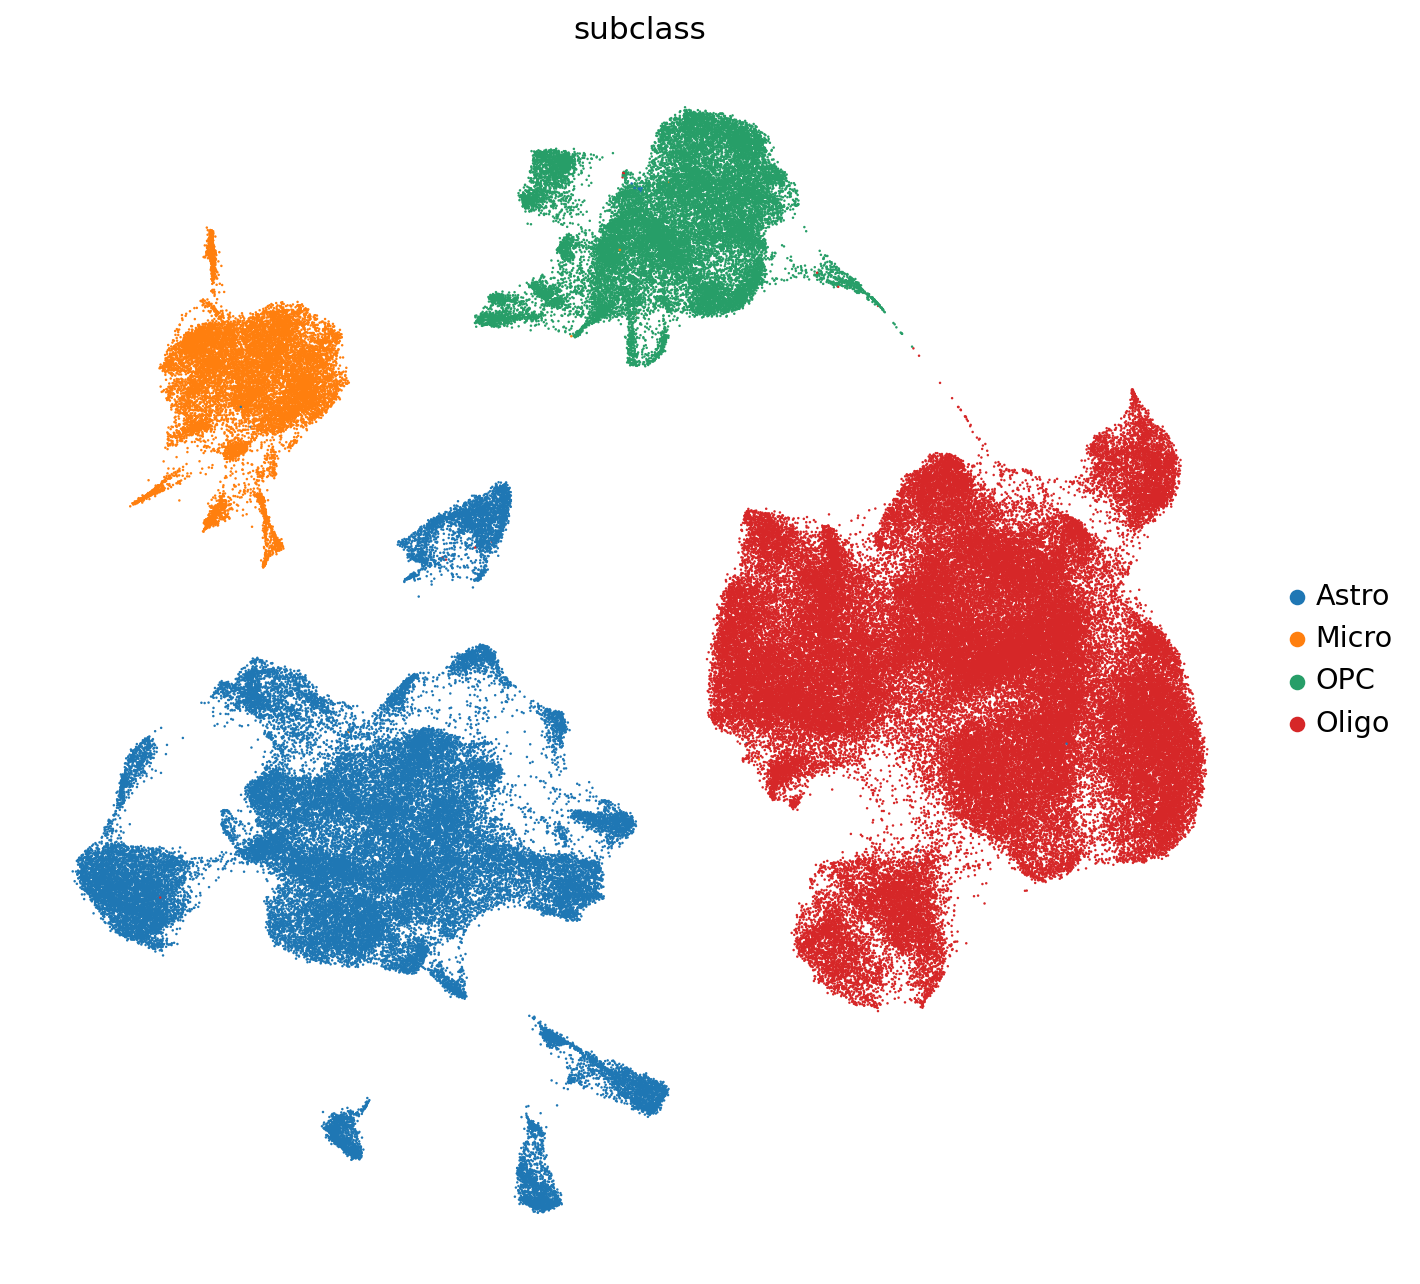

In [10]:
glia = glia.copy()
scvi.model.SCVI.setup_anndata(glia, layer='logcounts',
                              categorical_covariate_keys=['study'],
                              #continuous_covariate_keys=["Age at Death"]
                             )
model = scvi.model.SCVI(glia)
model.train()

SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
glia.obsm[SCVI_LATENT_KEY] = latent
latent.shape
sc.pp.neighbors(glia, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(glia, min_dist=0.3)
sc.set_figure_params(figsize=(10, 10))
sc.pl.umap(
    glia,
    color=["subclass"],
    frameon=False,
    size=5
)

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


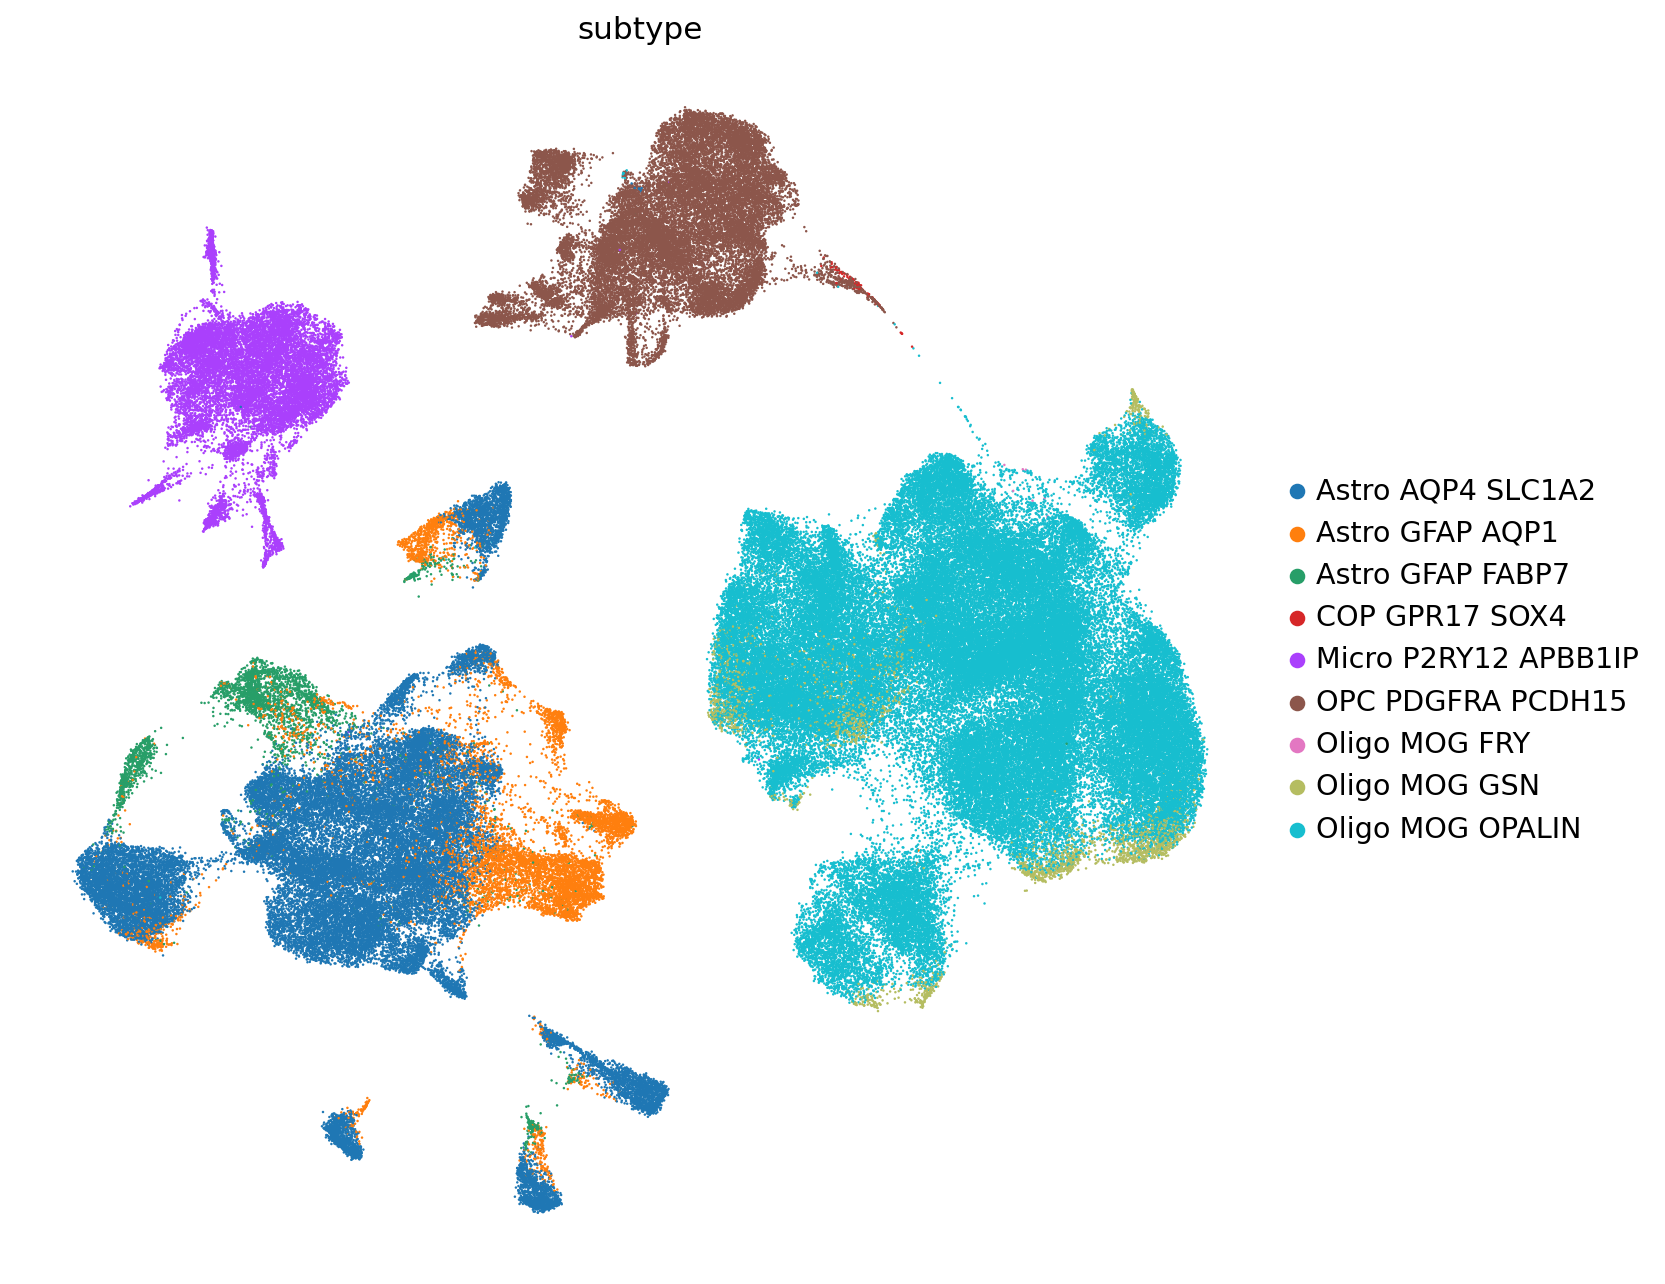

In [11]:
sc.pl.umap(
    glia,
    color=["subtype"],
    frameon=False,
    size=5
)

In [41]:
glia.var_names=glia.var.gene_ids
glia.write_h5ad('../../SCORCH_HIV/glia_updated.h5ad',compression='gzip')

In [8]:
glia_upd = sc.read_h5ad('../../SCORCH_HIV/glia_updated.h5ad')